In [2]:
import sagemaker

In [3]:
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

AWS Region: us-east-1
RoleArn: arn:aws:iam::522245616752:role/service-role/SageMaker-himal


In [4]:
import os
import boto3
import re
import copy
import time

from time import gmtime, strftime
from sagemaker import get_execution_role

In [5]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/xgboost-mnist'

In [6]:
# Download Data
import pickle, gzip, urllib.request, json
import numpy as np

In [8]:
%%time

# payload_url = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
# payload_url = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz"
payload_filename = 'mnist.pkl.gz'

# urllib.request.urlretrieve(payload_url, payload_filename)

with gzip.open(payload_filename, 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 774 ms, sys: 448 ms, total: 1.22 s
Wall time: 1.58 s


# Explore the training data

In [9]:
%matplotlib inline
import matplotlib.pyplot as plot

plot.rcParams['figure.figsize'] = (2, 10)

This is a 5


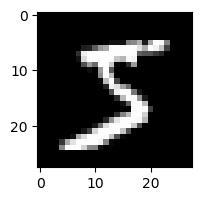

This is a 0


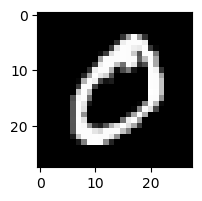

This is a 4


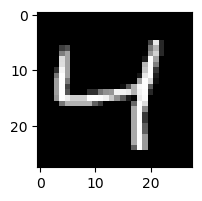

This is a 1


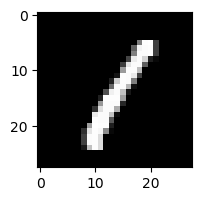

This is a 9


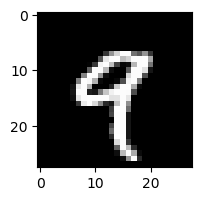

This is a 2


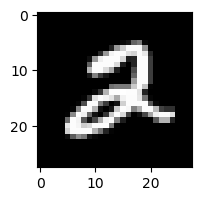

This is a 1


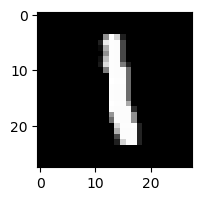

This is a 3


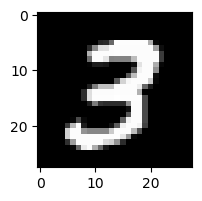

This is a 1


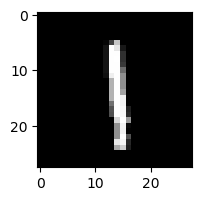

This is a 4


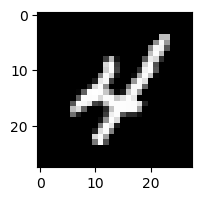

In [10]:
for i in range(0, 10):
    image = train_set[0][i]
    label = train_set[1][i]
    
    image_reshaped = image.reshape((28, 28))
    image_plot = plot.imshow(image_reshaped, cmap='gray')
    
    print('This is a {}'.format(label))
    plot.show()

# Transform the Training Dataset and Upload it to Amazon S3

In [11]:
import struct
import io
import csv
import boto3

In [12]:
def convert_data():
    data_partitions = [
        ('train', train_set),
        ('validation', valid_set),
        ('test', test_set)
    ]
    
    for data_partition_name, data_partition in data_partitions:
        shape1 = data_partition[0].shape
        shape2 = data_partition[1].shape
        
        print('{}: {} {}'.format(data_partition_name, shape1, shape2))
        
        # :: ---
        
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis = 1)
        else:
            examples = features
            
        np.savetxt('data.csv', examples, delimiter = ',')
        
        # :: ---
        
        key = '{}/{}/examples'.format(prefix, data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        
        print('Done writing to {}'.format(url))


In [13]:
%%time
convert_data()

train: (50000, 784) (50000,)
Done writing to s3://sagemaker-us-east-1-522245616752/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3://sagemaker-us-east-1-522245616752/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3://sagemaker-us-east-1-522245616752/sagemaker/xgboost-mnist/test/examples
CPU times: user 38.3 s, sys: 20.3 s, total: 58.6 s
Wall time: 1min 3s


# Train a Model

In [14]:
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

In [15]:
uri_template = 's3://{}/{}/{}'

train_data = uri_template.format(bucket, prefix, 'train')
validation_data = uri_template.format(bucket, prefix, 'validation')
output_location = uri_template.format(bucket, prefix, 'xgboost_model_sdk')

print(train_data)
print(validation_data)
print(output_location)

s3://sagemaker-us-east-1-522245616752/sagemaker/xgboost-mnist/train
s3://sagemaker-us-east-1-522245616752/sagemaker/xgboost-mnist/validation
s3://sagemaker-us-east-1-522245616752/sagemaker/xgboost-mnist/xgboost_model_sdk


In [35]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

xgb_model = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count = 1,
    train_instance_type = 'ml.m5.xlarge',
    train_volume_size = 5,
    output_path = output_location,
    sagemaker_session = sagemaker.Session()
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [36]:
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    silent = 0,
    objective = 'multi:softmax',
    num_class = 10,
    num_round = 10
)

In [37]:
# :: create the training channels for the training job.
#    we're using both training and validation channels for this model.

train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {
    'train': train_channel,
    'validation': valid_channel
}

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [38]:
# :: start model training

xgb_model.fit(
    inputs = data_channels,
    logs = True
)

INFO:sagemaker:Creating training-job with name: xgboost-2023-03-07-01-52-54-279


2023-03-07 01:52:54 Starting - Starting the training job...
2023-03-07 01:53:17 Starting - Preparing the instances for training......
2023-03-07 01:54:07 Downloading - Downloading input data...
2023-03-07 01:54:53 Training - Training image download completed. Training in progress...Arguments: train
[2023-03-07:01:55:02:INFO] Running standalone xgboost training.
[2023-03-07:01:55:02:INFO] File size need to be processed in the node: 1122.95mb. Available memory size in the node: 8279.55mb
[2023-03-07:01:55:02:INFO] Determined delimiter of CSV input is ','
[01:55:02] S3DistributionType set as FullyReplicated
[01:55:05] 50000x784 matrix with 39200000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-03-07:01:55:05:INFO] Determined delimiter of CSV input is ','
[01:55:05] S3DistributionType set as FullyReplicated
[01:55:05] 10000x784 matrix with 7840000 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[01:55:06] sr

In [ ]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count = 1,
    instance_type='ml.m5.xlarge'
)

INFO:sagemaker:Creating model with name: xgboost-2023-03-07-01-57-35-818
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-03-07-01-57-35-818
INFO:sagemaker:Creating endpoint with name xgboost-2023-03-07-01-57-35-818


---